### 3.2.3 深度神经网络设计
在AlexNet当中，其设计不太规则，让人感觉比较随意，没有提供一个通用的模板来指导后续的研究人员设计新的网络。 后面将介绍一些常用于设计深层神经网络的启发式概念。

#### VGG 使用块的网络
与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

##### VGG块
经典卷积神经网络的基本组成部分是下面的这个序列：
 1. 带填充以保持分辨率的卷积层。
 2. 非线性激活函数，如ReLU。
 3. 汇聚层，如最大汇聚层。

而对VGG块来说:
如何训练更深更大网路：
* 选项
  * 更多的全连接层（太贵）
  * 更多的卷积层
  * **将卷积层组合成块**(VGG核心思想)

一个VGG块由一系列**卷积层**组成，后面再加上用于空间下采样的**最大汇聚层**。

该函数有三个参数，分别对应于卷积层的数量`num_convs`、输入通道的数量`in_channels` 和输出通道的数量`out_channels`。
我们下面[原始论文](https://arxiv.org/abs/1409.1556)中的网络结构:

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

##### VGG网络
VGG网络可以分为两部分：
* 第一部分主要由**卷积层**和**汇聚层**组成
* 第二部分由**全连接层**组成

![](https://zh-v2.d2l.ai/_images/vgg.svg)

其中有超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

下面的代码实现了VGG-11。可以通过在conv_arch上执行for循环来简单实现。

In [5]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

下面构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


#### 训练模型
由于VGG-11比AlexNet计算量更大，因此构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.172, train acc 0.936, test acc 0.923
366.9 examples/sec on cuda:0


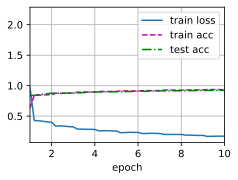

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())